In [16]:

import datetime
import os
import cv2
import glob
import h5py
import sys
import optparse
import copy
import scipy.io

import pylab as pl
from collections import Counter
import seaborn as sns

import numpy as np
import pylab as pl
import pandas as pd
import seaborn as sns
import tifffile as tf

from pipeline.python.classifications import test_responsivity as resp 
from pipeline.python.utils import natural_keys, label_figure

from pipeline.python.utils import uint16_to_RGB
from skimage import exposure
from matplotlib import patches


In [3]:
%matplotlib notebook

In [4]:

from scipy import stats
from scipy.interpolate import interp1d
import scipy.optimize as spopt

In [5]:
class Struct():
    pass

# Load data

In [6]:
output_dir = os.path.join(rootdir, 'tmp_summaries')
#output_dir = os.path.join(traceid_dir, 'figures', 'population', 'corr')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [43]:
rootdir = '/n/coxfs01/2p-data'
trace_type = 'dff'

run = 'combined_blobs_static'
traceid = 'traces001'

# ------------------------------------------------------------
# visual_area = 'V1'
# #animals = ['JC084', 'JC085']
# #sessions = ['20190522', '20190622']

# sessions = ['20190613', '20190616', '20190617'] #, '20190510', '20190511']
# animals = ['JC097' for _ in range(len(sessions))]

# fovs = ['FOV1_zoom2p0x' for _ in range(len(sessions))]

# JC083: 20190507, 20190510, 20190511
# JC084: 20190522
# JC085:  20190622
# JC097: 20190613, 20190616, 20190617
# ------------------------------------------------------------


visual_area = 'LI'
#animals = ['JC076', 'JC090']
#sessions = ['20190502', '20190605']


sessions = ['20190609', '20190612', '20190617'] #, '20190510', '20190511']
animals = ['JC099' for _ in range(len(sessions))]

fovs = ['FOV1_zoom2p0x' for _ in range(len(sessions))]

# JC076: 20190502
# JC090: 20190605
# JC091:  '20190602', '20190606', '20190607', '20190614'
# JC099: 20190609, 20190612, 20190617
# ------------------------------------------------------------



In [44]:
# animals = ['JC099', 'JC099', 'JC099']

# sessions = ['20190609', '20190612', '20190617']
# fovs = ['FOV1_zoom2p0x' for _ in range(len(sessions))]


In [45]:
# for animalid, session, fov in zip(animals, sessions, fovs):
#     print("[%s] %s - %s ... processing..." % (animalid, session, fov))
#     fov_dir = os.path.join(rootdir, animalid, session, fov)
#     traceid_dirs = glob.glob(os.path.join(fov_dir, run, 'traces', '%s*' % traceid))
#     if len(traceid_dirs) > 1:
#         print "More than 1 trace ID found:"
#         for ti, traceid_dir in enumerate(traceid_dirs):
#             print ti, traceid_dir
#         sel = input("Select IDX of traceid to use: ")
#         traceid_dir = traceid_dirs[int(sel)]
#     else:
#         traceid_dir = traceid_dirs[0]
#     #traceid = os.path.split(traceid_dir)[-1]


#     data_fpath = glob.glob(os.path.join(traceid_dir, 'data_arrays', '*.npz'))[0]
#     dset = np.load(data_fpath)


#     traceid_dir =  glob.glob(os.path.join(rootdir, animalid, session, fov, run, 'traces', '%s*' % traceid))[0]
#     data_fpath = glob.glob(os.path.join(traceid_dir, 'data_arrays', 'datasets.npz'))[0]
#     dset = np.load(data_fpath)


#     raw_traces = pd.DataFrame(dset[trace_type])
#     labels = pd.DataFrame(data=dset['labels_data'], columns=dset['labels_columns'])
#     sdf = pd.DataFrame(dset['sconfigs'][()]).T

#     fr = 44.65 #dset['run_info'][()]['framerate']
#     nframes_on = labels['nframes_on'].unique()[0]
#     stim_on_frame = labels['stim_on_frame'].unique()[0]
#     nframes_post_onset = nframes_on + int(round(1.*fr))


#     gdf = resp.group_roidata_stimresponse(raw_traces.values, labels) # Each group is roi's trials x metrics
#     #gdf = resp.get_roi_response_by_trial(raw_traces.values, labels)
#     #gratings_df_by_rois.get_group(roi_list[0])
#     nrois_total = len(gdf.groups)
#     print("... Total of %i rois selected for this FOV" % nrois_total)


#     # Get responsive cells:
#     response_type = 'dff'
#     response_thr = 0.1
#     goodness_type = 'zscore'
#     goodness_thr = 2.0
#     roi_list = [k for k, g in gdf if g.groupby(['config']).mean()[response_type].max() >= response_thr\
#                 and g.groupby(['config']).mean()[goodness_type].max() >= goodness_thr] #\
#     print("... %i out of %i cells meet min %s req. of %.2f" % (len(roi_list), nrois_total, response_type, response_thr))


In [47]:
metric_type = 'meanstim'

for animalid, session, fov in zip(animals, sessions, fovs):
    print("[%s] %s - %s ... processing..." % (animalid, session, fov))
    fov_dir = os.path.join(rootdir, animalid, session, fov)
    traceid_dirs = glob.glob(os.path.join(fov_dir, run, 'traces', '%s*' % traceid))
    if len(traceid_dirs) > 1:
        print "More than 1 trace ID found:"
        for ti, traceid_dir in enumerate(traceid_dirs):
            print ti, traceid_dir
        sel = input("Select IDX of traceid to use: ")
        traceid_dir = traceid_dirs[int(sel)]
    else:
        traceid_dir = traceid_dirs[0]
    #traceid = os.path.split(traceid_dir)[-1]


    data_fpath = glob.glob(os.path.join(traceid_dir, 'data_arrays', '*.npz'))[0]
    dset = np.load(data_fpath)


    traceid_dir =  glob.glob(os.path.join(rootdir, animalid, session, \
                                          fov, run, 'traces', '%s*' % traceid))[0]
    data_fpath = glob.glob(os.path.join(traceid_dir, 'data_arrays', 'datasets.npz'))[0]
    dset = np.load(data_fpath)


    raw_traces = pd.DataFrame(dset[trace_type])
    labels = pd.DataFrame(data=dset['labels_data'], columns=dset['labels_columns'])
    sdf = pd.DataFrame(dset['sconfigs'][()]).T

    fr = 44.65 #dset['run_info'][()]['framerate']
    nframes_on = labels['nframes_on'].unique()[0]
    stim_on_frame = labels['stim_on_frame'].unique()[0]
    nframes_post_onset = nframes_on + int(round(1.*fr))


    gdf = resp.group_roidata_stimresponse(raw_traces.values, labels) # Each group is roi's trials x metrics
    #gdf = resp.get_roi_response_by_trial(raw_traces.values, labels)
    #gratings_df_by_rois.get_group(roi_list[0])
    nrois_total = len(gdf.groups)
    print("... Total of %i rois selected for this FOV" % nrois_total)


    # Get responsive cells:
    response_type = 'dff'
    response_thr = 0.1
    goodness_type = 'zscore'
    goodness_thr = 2.0
    roi_list = [k for k, g in gdf if g.groupby(['config']).mean()[response_type].max() >= response_thr\
                and g.groupby(['config']).mean()[goodness_type].max() >= goodness_thr] #\
    print("... %i out of %i cells meet min %s req. of %.2f" % (len(roi_list), nrois_total, response_type, response_thr))

    
    
    # Format data, get corrs, save as mat
    sdf = pd.DataFrame(dset['sconfigs'][()]).T
    sdf = sdf[sdf['morphlevel']!=-1] # get rid of controls for now
    # Make sure size is int
    tmp_sz = [int(round(i)) if i is not None else i for i in sdf['size']]
    sdf['size'] = tmp_sz
    tested_sizes = [s for s in sdf['size'].unique() if not np.isnan(s)] 

    # Create array of response vectors:
    rvectors = dict((curr_cfg, np.array([roidf[roidf['config']==curr_cfg].mean()[metric_type]\
                        for roi, roidf in gdf])) for curr_cfg in sdf.index.tolist())
    ddf = pd.DataFrame(rvectors)
    print ddf.shape
    df = ddf.loc[roi_list]
    print df.shape
    df.head()
    cmat = df.corr()

    # Change columns names to meaningful:
    cmat.columns = ['%i_%i' % (int(sdf['morphlevel'][cfg]), int(sdf['size'][cfg])) for cfg in cmat.columns.tolist()]
    cmat.index = ['%i_%i' % (int(sdf['morphlevel'][cfg]), int(sdf['size'][cfg])) for cfg in cmat.index.tolist()]

    ## Group by size:

    corr_dict = {}
    for sz in tested_sizes:
        cfg_strs = [c for c in cmat.columns if '_%i' % sz in c]
        corr_dict['sz%i' % sz] = np.array(cmat.loc[cfg_strs, cfg_strs].values)
        corr_dict['full'] = np.array(cmat)
        
    # corr_dict = {}
    # for sz in tested_sizes:
    #     curr_cfgs = sdf[sdf['size']==sz].index.tolist()
    #     rvectors = dict((curr_cfg, np.array([roidf[roidf['config']==curr_cfg].mean()['meanstim']\
    #                         for roi, roidf in gdf])) for curr_cfg in curr_cfgs )
    #     ddf = pd.DataFrame(rvectors)
    #     df = ddf.loc[roi_list]
    #     print df.shape
    #     corr_dict['sz%i' % sz] = np.array(df.corr().values)


    outfile_name = '_'.join([visual_area, animalid, session, fov.split('_')[0]])
    if metric_type == 'zscore':
        outfile_path = os.path.join(output_dir, '%s_corrs_%s.mat' % (outfile_name, metric_type))
    else:
        outfile_path = os.path.join(output_dir, '%s_corrs.mat' % (outfile_name))

    scipy.io.savemat(outfile_path, corr_dict)
    print("... Done: saved to - %s" % outfile_name)


[JC099] 20190609 - FOV1_zoom2p0x ... processing...
... Total of 311 rois selected for this FOV
... 6 out of 311 cells meet min dff req. of 0.10
(311, 45)
(6, 45)
... Done: saved to - LI_JC099_20190609_FOV1
[JC099] 20190612 - FOV1_zoom2p0x ... processing...
... Total of 269 rois selected for this FOV
... 24 out of 269 cells meet min dff req. of 0.10
(269, 45)
(24, 45)
... Done: saved to - LI_JC099_20190612_FOV1
[JC099] 20190617 - FOV1_zoom2p0x ... processing...
... Total of 102 rois selected for this FOV
... 7 out of 102 cells meet min dff req. of 0.10
(102, 45)
(7, 45)
... Done: saved to - LI_JC099_20190617_FOV1


In [165]:
cfg_strs = [c for c in cmat.columns if '_50' in c]
cfg_strs

['0_50',
 '14_50',
 '27_50',
 '40_50',
 '53_50',
 '66_50',
 '79_50',
 '92_50',
 '106_50']

In [168]:
corr_dict['sz50'] == cmat.loc[cfg_strs, cfg_strs].values

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True]], dtype=bool)

<IPython.core.display.Javascript object>


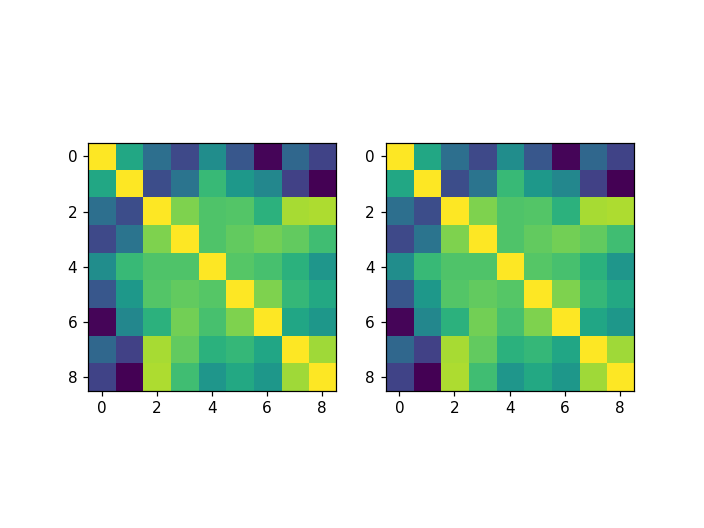

In [167]:
fig, ax = pl.subplots(1,2)
ax[0].imshow(cmat.loc[cfg_strs, cfg_strs])

ax[1].imshow(corr_dict['sz50'])

# Look at 1 cell

<IPython.core.display.Javascript object>


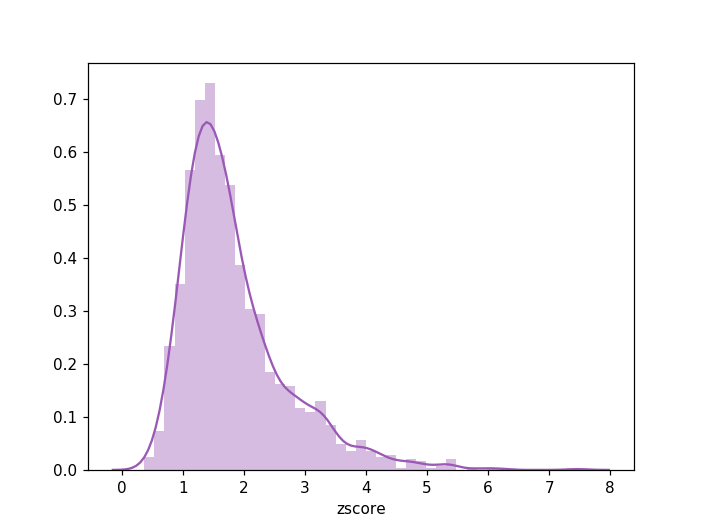

In [91]:
roi = 17
pl.figure()
sns.distplot(gdf.get_group(17)['zscore'])

In [119]:
sdf = pd.DataFrame(dset['sconfigs'][()]).T


# Make sure size is int
tmp_sz = [int(round(i)) if i is not None else i for i in sdf['size']]
sdf['size'] = tmp_sz

In [121]:
sdf.loc[sdf['morphlevel']==-1, 'size'] 

config001   NaN
config002   NaN
config003   NaN
config004   NaN
config005   NaN
Name: size, dtype: float64

In [122]:
tested_sizes = [s for s in sdf['size'].unique() if not np.isnan(s)]
tested_sizes

[10.0, 20.0, 30.0, 40.0, 50.0]

In [123]:
include_controls = False
if include_controls:
    for s, newsz in zip(sdf[sdf['morphlevel']==-1].index.tolist(), tested_sizes):
        sdf.loc[s, 'size'] = newsz


In [124]:
gdf.get_group(17).groupby(['config']).mean()

,base_mean,base_std,df,dff,meanstim,snr,zscore
config,,,,,,,
config001,0.112317,0.084413,-0.006204,0.044154,0.106113,1.044154,1.253830
config002,0.112295,0.082883,-0.003624,0.248542,0.108672,1.248542,1.297021
config003,0.120057,0.081055,-0.020235,-0.032503,0.099821,0.967497,1.234911
config004,0.109539,0.081021,-0.008417,0.323461,0.101122,1.323461,1.272557
config005,0.122220,0.086652,-0.029020,-0.042301,0.093200,0.957699,1.061348
config006,0.117632,0.080932,0.000244,0.089834,0.117875,1.089834,1.453538
config007,0.088305,0.079562,0.038981,0.021025,0.127286,1.021025,1.595600
config008,0.123112,0.080324,0.076863,1.039356,0.199975,2.039356,2.496703
config009,0.096707,0.079106,0.104433,1.488068,0.201140,2.488068,2.601858


In [69]:
curr_cfgs = sdf[sdf['size']==50].index.tolist()
roi_df = gdf.get_group(17)


meanr = roi_df[roi_df['config'].isin(curr_cfgs)].groupby(['config']).mean()['meanstim']

pl.figure();
pl.plot(meanr)

#### Get responsive cells

In [100]:
response_type = 'dff'
response_thr = 0.1
goodness_type = 'zscore'
goodness_thr = 2.0

roi_list = [k for k, g in gdf if g.groupby(['config']).mean()[response_type].max() >= response_thr\
            and g.groupby(['config']).mean()[goodness_type].max() >= goodness_thr] #\

print("%i out of %i cells meet min %s req. of %.2f" % (len(roi_list), nrois_total, response_type, response_thr))

In [101]:
roi_list = [k for k, g in gdf if g.groupby(['config']).mean()[response_type].max() >= response_thr\
            and g.groupby(['config']).mean()[goodness_type].max() >= goodness_thr] #\

print("%i out of %i cells meet min %s req. of %.2f" % (len(roi_list), nrois_total, response_type, response_thr))

75 out of 260 cells meet min dff req. of 0.10


In [159]:
sdf = sdf[sdf['morphlevel']!=-1]
sdf

,color,morphlevel,object,size,stimtype,xpos,ypos,yrot
config006,,0,Blob_N1,10.0,image,20,-8,0
config007,,0,Blob_N1,20.0,image,20,-8,0
config008,,0,Blob_N1,30.0,image,20,-8,0
config009,,0,Blob_N1,40.0,image,20,-8,0
config010,,0,Blob_N1,50.0,image,20,-8,0
config011,,14,morph14,10.0,image,20,-8,0
config012,,14,morph14,20.0,image,20,-8,0
config013,,14,morph14,30.0,image,20,-8,0
config014,,14,morph14,40.0,image,20,-8,0
config015,,14,morph14,50.0,image,20,-8,0


In [160]:
rvectors = dict((curr_cfg, np.array([roidf[roidf['config']==curr_cfg].mean()['meanstim']\
                    for roi, roidf in gdf])) for curr_cfg in sdf.index.tolist())



# roi, roidf
# meanr = roi_df[roi_df['config'].isin(curr_cfgs)].groupby(['config']).mean()['meanstim']


ddf = pd.DataFrame(rvectors)
print ddf.shape
df = ddf.loc[roi_list]
print df.shape
df.head()

cmat = df.corr()

# Change columns names to meaningful:
cmat.columns = ['%i_%i' % (int(sdf['morphlevel'][cfg]), int(sdf['size'][cfg])) for cfg in cmat.columns.tolist()]
cmat.index = ['%i_%i' % (int(sdf['morphlevel'][cfg]), int(sdf['size'][cfg])) for cfg in cmat.index.tolist()]


(260, 45)
(75, 45)


In [163]:
cmat

,0_10,0_20,0_30,0_40,0_50,14_10,14_20,14_30,14_40,14_50,...,92_10,92_20,92_30,92_40,92_50,106_10,106_20,106_30,106_40,106_50
0_10,1.000000,0.775370,0.639800,0.829007,0.714328,0.938566,0.634089,0.679534,0.717083,0.474305,...,0.941822,0.729982,0.706189,0.594545,0.652287,0.859892,0.654230,0.634490,0.487219,0.674844
0_20,0.775370,1.000000,0.677219,0.666552,0.627045,0.765644,0.901066,0.762289,0.652958,0.516272,...,0.764281,0.890404,0.788746,0.632867,0.620278,0.756720,0.867844,0.780907,0.541475,0.584156
0_30,0.639800,0.677219,1.000000,0.699065,0.620093,0.612274,0.715622,0.767409,0.635224,0.600637,...,0.627166,0.661410,0.672199,0.510723,0.456496,0.543876,0.686607,0.607564,0.509343,0.422939
0_40,0.829007,0.666552,0.699065,1.000000,0.867999,0.777044,0.499274,0.732839,0.827429,0.699023,...,0.766718,0.595269,0.712705,0.676412,0.759360,0.638762,0.504793,0.585656,0.591839,0.722540
0_50,0.714328,0.627045,0.620093,0.867999,1.000000,0.682302,0.465132,0.718254,0.849801,0.875900,...,0.675862,0.529965,0.652433,0.704160,0.792797,0.570573,0.463444,0.542184,0.684910,0.751677
14_10,0.938566,0.765644,0.612274,0.777044,0.682302,1.000000,0.658292,0.711068,0.691755,0.486471,...,0.970705,0.744595,0.739255,0.633194,0.660205,0.934825,0.710125,0.658035,0.501188,0.648204
14_20,0.634089,0.901066,0.715622,0.499274,0.465132,0.658292,1.000000,0.730906,0.505379,0.458507,...,0.671396,0.902612,0.721773,0.559033,0.475783,0.715337,0.918668,0.762170,0.478561,0.435016
14_30,0.679534,0.762289,0.767409,0.732839,0.718254,0.711068,0.730906,1.000000,0.821140,0.711366,...,0.712232,0.781901,0.890074,0.854356,0.789421,0.705616,0.754888,0.844586,0.764287,0.751062
14_40,0.717083,0.652958,0.635224,0.827429,0.849801,0.691755,0.505379,0.821140,1.000000,0.784714,...,0.682673,0.678520,0.798051,0.859293,0.890818,0.637097,0.543332,0.735725,0.831477,0.898226
14_50,0.474305,0.516272,0.600637,0.699023,0.875900,0.486471,0.458507,0.711366,0.784714,1.000000,...,0.473979,0.491176,0.605728,0.729019,0.749119,0.423126,0.445102,0.495721,0.771640,0.688611


<IPython.core.display.Javascript object>


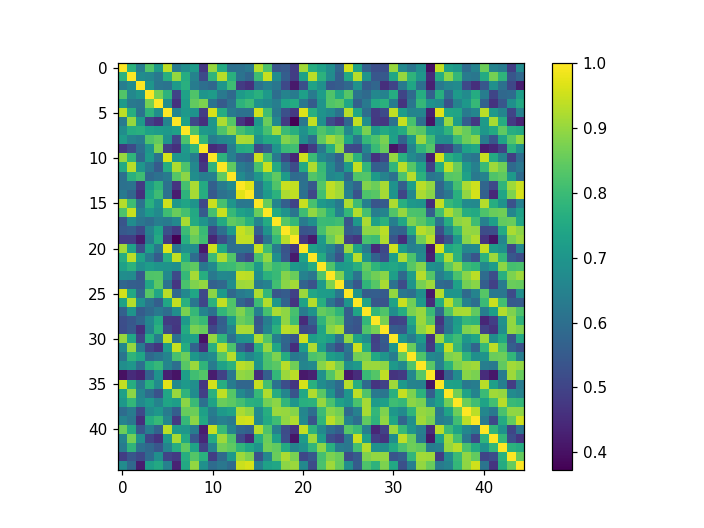

In [164]:
pl.figure()
pl.imshow(cmat)
pl.colorbar()

In [125]:
sdf

,color,morphlevel,object,size,stimtype,xpos,ypos,yrot
config001,0.08,-1,control,NaN,image,None,None,0
config002,0.2,-1,control,NaN,image,None,None,0
config003,0.32,-1,control,NaN,image,None,None,0
config004,0.44,-1,control,NaN,image,None,None,0
config005,0.56,-1,control,NaN,image,None,None,0
config006,,0,Blob_N1,10.0,image,20,-8,0
config007,,0,Blob_N1,20.0,image,20,-8,0
config008,,0,Blob_N1,30.0,image,20,-8,0
config009,,0,Blob_N1,40.0,image,20,-8,0
config010,,0,Blob_N1,50.0,image,20,-8,0


#### Separate by size:


In [126]:
print tested_sizes

[10.0, 20.0, 30.0, 40.0, 50.0]


In [142]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar


<IPython.core.display.Javascript object>


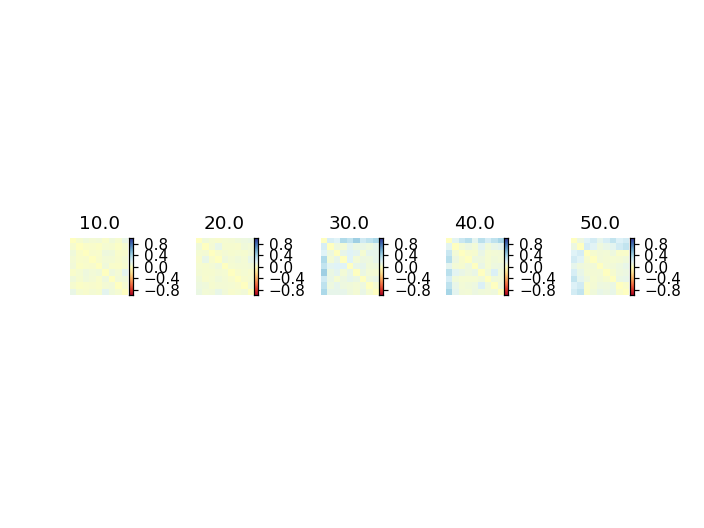

In [152]:
fig, axes = pl.subplots(1,len(tested_sizes))
for sz, ax in zip(tested_sizes, axes):
    im = ax.imshow(1-np.array(corr_dict['sz%i' % sz]), vmin=-1, vmax=1, cmap='RdYlBu')
    ax_divider = make_axes_locatable(ax)
    # add an axes to the right of the main axes.
    cax = ax_divider.append_axes("right", size="7%", pad="2%")
    cb = colorbar(im, cax=cax)
    ax.set_title(sz)
    ax.axis('off')
    
    
pl.subplots_adjust(wspace=1, left=0.1, right=0.9)

In [153]:
output_dir = os.path.join(traceid_dir, 'figures', 'population', 'corr')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
outfile_path = os.path.join(output_dir, 'corrs.mat')

In [155]:
import scipy.io

#scipy.io.savemat(outfile_path, {'struct':df.to_dict("list")})
#scipy.io.savemat(outfile_path, corr_dict, oned_as='row')
scipy.io.savemat(outfile_path, corr_dict)




In [149]:
outfile_path

'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_ea0b53_traces001_92d492_traces001_af4cfd_traces001_9188fa_traces001_b44714_traces001_133108/figures/population/corr/corrs.mat'

In [ ]:
fig_subdir = 'corrs_%s' % roi_selector 

if segment:
    curr_figdir = os.path.join(traceid_dir, 'figures', 'population', fig_subdir, visual_area)
else:
    curr_figdir = os.path.join(traceid_dir, 'figures', 'population', fig_subdir)
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)
print "Saving plots to: %s" % curr_figdir
